In [1]:
from realtime_agent.Agent import Agent, get_state
from services.StockService import StockService
from utils import date_utils
%matplotlib notebook 

from sklearn.preprocessing import MinMaxScaler
import numpy as np
from realtime_agent.Model import Model

import matplotlib.pyplot as plt
import seaborn as sns
from services.EquityToLegacyDataConversionService import EquityToLegacyDataConversionService 
sns.set()

# df = pd.read_csv('FB.csv')
days_desired = 253 * 2
latest_date = date_utils.parse_datestring("2019-05-23")
df = EquityToLegacyDataConversionService.get_symbol("FB", num_records=days_desired, latest_date=latest_date)
df.head()

About to make logging dir (if nec): C:\Users\Chris\logs\stock_predictor
Setting up logging...
Creating logger config ...
Creating logger services.spark.spark_split_eod_data ...
Creating logger services.split_eod_data_to_files_service ...
Creating logger services.eod_data_service ...
Creating logger services.EquityUtilService ...
Creating logger services.chart_service ...
Creating logger services.StockService ...


In [4]:
parameters = [df['Close'].tolist(), df['Volume'].tolist()]

Our output size from `get_state` is 38. In this notebook, I only use `Close` and `Volume` parameters, you can choose any parameters you want from your DataFrame.

After that, I want to add another parameters, my `inventory` size, mean of `inventory` and `capital`.

Let say for an example,
```
inventory_size = 1
mean_inventory = 0.5
capital = 2
last_state = 0
```

We have 3 actions,

1. `0` for do nothing.
2. `1` for buy.
3. `2` for sell.

In [6]:
inventory_size = 1
mean_inventory = 0.5
capital = 2
concat_parameters = np.concatenate([get_state(parameters, 20), [[inventory_size, 
                                                                mean_inventory,
                                                                capital]]], axis = 1)

In [7]:
input_size = concat_parameters.shape[1]
input_size

79

In [10]:
# stocks = [i for i in os.listdir(os.getcwd()) if '.csv' in i and not 'TWTR' in i]
num_symb_desired = 100
stocks = StockService.get_random_symbols_with_date(num_symb_desired, desired_trading_days=days_desired, end_date=latest_date)
stocks

['GOOG', 'FB', 'LB', 'MTDR', 'CPRT', 'FSV', 'AMD', 'TSLA', 'SINA', 'GWR']

I want to train on all stocks I downloaded except for Twitter. I want to use Twitter for testing.

In [11]:
skip = 1
layer_size = 500
output_size = 3

model = Model(input_size = input_size, layer_size = layer_size, output_size = output_size)
agent = None

for no, stock in enumerate(stocks):
    print('training stock %s'%(stock))
    # df = pd.read_csv(stock)
    df = EquityToLegacyDataConversionService.get_symbol(stock, num_records=days_desired, latest_date=latest_date)
    real_trend = df['Close'].tolist()
    parameters = [df['Close'].tolist(), df['Volume'].tolist()]
    minmax = MinMaxScaler(feature_range = (100, 200)).fit(np.array(parameters).T)
    scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
    initial_money = np.max(parameters[0]) * 2
    
    if no == 0:
        agent = Agent(model = model,
                      timeseries = scaled_parameters,
                      skip = skip,
                      initial_money = initial_money,
                      real_trend = real_trend,
                      minmax = minmax)
    else:
        agent.change_data(timeseries = scaled_parameters,
                          skip = skip,
                          initial_money = initial_money,
                          real_trend = real_trend,
                          minmax = minmax)
    
    agent.fit(iterations = 100, checkpoint = 10)
    print()

### If you saw the whole training session on certain stocks are negatives (like FB), means that, that stock markets are losing very bad

In [13]:
# df = pd.read_csv('GOOG.csv')
df = EquityToLegacyDataConversionService.get_symbol("GOOG", num_records=days_desired, latest_date=latest_date)

real_trend = df['Close'].tolist()
parameters = [df['Close'].tolist(), df['Volume'].tolist()]
minmax = MinMaxScaler(feature_range = (100, 200)).fit(np.array(parameters).T)
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
initial_money = np.max(parameters[0]) * 2

    
agent.change_data(timeseries = scaled_parameters,
                  skip = skip,
                  initial_money = initial_money,
                  real_trend = real_trend,
                  minmax = minmax)

C:\Users\Chris\workspaces\stock-predictor\services\EquityToLegacyDataConversionService.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df.sort_values(by='date', inplace=True)


In [14]:
states_buy, states_sell, total_gains, invest = agent.buy()

0 [0. 1. 0.]
day 0: buy 1 unit at price 934.010000, total balance 1641.150000
1 [0. 1. 0.]
day 1: buy 1 unit at price 941.860000, total balance 699.290000
2 [0. 1. 0.]
day 2: buy 1 unit at price 948.820000, total balance -249.530000
3 [0. 1. 0.]
day 3: buy 1 unit at price 954.960000, total balance -1204.490000
4 [0. 1. 0.]
5 [1. 0. 0.]
6 [0. 1. 0.]
7 [0. 1. 0.]
8 [0. 1. 0.]
9 [0. 1. 0.]
10 [1. 0. 0.]
11 [0. 1. 0.]
12 [1. 0. 0.]
13 [0. 1. 0.]
14 [0. 0. 1.]
day 14, sell 1 unit at price 949.830000, investment 1.693772 %, total balance -254.660000,
15 [0. 0. 1.]
day 15, sell 1 unit at price 942.900000, investment 0.110420 %, total balance 688.240000,
16 [0. 1. 0.]
day 16: buy 1 unit at price 953.400000, total balance -265.160000
17 [0. 1. 0.]
day 17: buy 1 unit at price 950.760000, total balance -1215.920000
18 [0. 0. 1.]
day 18, sell 1 unit at price 942.310000, investment -0.686115 %, total balance -273.610000,
19 [0. 1. 0.]
day 19: buy 1 unit at price 939.780000, total balance -1213.3900

158 [0. 1. 0.]
159 [0. 1. 0.]
160 [1. 0. 0.]
161 [0. 1. 0.]
162 [1. 0. 0.]
163 [1. 0. 0.]
164 [0. 1. 0.]
165 [0. 1. 0.]
166 [0. 1. 0.]
167 [0. 1. 0.]
168 [0. 1. 0.]
169 [0. 1. 0.]
170 [0. 1. 0.]
171 [0. 1. 0.]
172 [0. 1. 0.]
173 [0. 1. 0.]
174 [0. 1. 0.]
175 [0. 1. 0.]
176 [0. 1. 0.]
177 [0. 1. 0.]
178 [0. 0. 1.]
day 178, sell 1 unit at price 1111.900000, investment 5.958813 %, total balance -226.770000,
179 [0. 0. 1.]
day 179, sell 1 unit at price 1055.800000, investment 0.898318 %, total balance 829.030000,
180 [0. 0. 1.]
day 180, sell 1 unit at price 1080.600000, investment 1.464789 %, total balance 1909.630000,
181 [0. 0. 1.]
day 181, sell 1 unit at price 1048.580000, investment -3.131698 %, total balance 2958.210000,
182 [0. 0. 1.]
183 [0. 0. 1.]
184 [0. 0. 1.]
185 [0. 0. 1.]
186 [1. 0. 0.]
187 [0. 0. 1.]
188 [1. 0. 0.]
189 [0. 0. 1.]
190 [1. 0. 0.]
191 [0. 0. 1.]
192 [1. 0. 0.]
193 [0. 0. 1.]
194 [0. 0. 1.]
195 [1. 0. 0.]
196 [1. 0. 0.]
197 [0. 1. 0.]
day 197: buy 1 unit at price

362 [0. 0. 1.]
363 [0. 0. 1.]
364 [0. 0. 1.]
365 [0. 0. 1.]
366 [0. 0. 1.]
367 [0. 0. 1.]
368 [0. 0. 1.]
369 [1. 0. 0.]
370 [0. 1. 0.]
day 370: buy 1 unit at price 1055.810000, total balance 2141.250000
371 [0. 1. 0.]
day 371: buy 1 unit at price 1093.390000, total balance 1047.860000
372 [0. 0. 1.]
day 372, sell 1 unit at price 1082.400000, investment 2.518446 %, total balance 2130.260000,
373 [0. 1. 0.]
day 373: buy 1 unit at price 1066.150000, total balance 1064.110000
374 [0. 0. 1.]
day 374, sell 1 unit at price 1038.630000, investment -5.008277 %, total balance 2102.740000,
375 [0. 0. 1.]
day 375, sell 1 unit at price 1036.050000, investment -2.823243 %, total balance 3138.790000,
376 [0. 0. 1.]
377 [1. 0. 0.]
378 [0. 0. 1.]
379 [1. 0. 0.]
380 [1. 0. 0.]
381 [1. 0. 0.]
382 [0. 1. 0.]
day 382: buy 1 unit at price 1023.880000, total balance 2114.910000
383 [0. 1. 0.]
day 383: buy 1 unit at price 1048.620000, total balance 1066.290000
384 [0. 1. 0.]
day 384: buy 1 unit at price 1044.

<IPython.core.display.Javascript object>


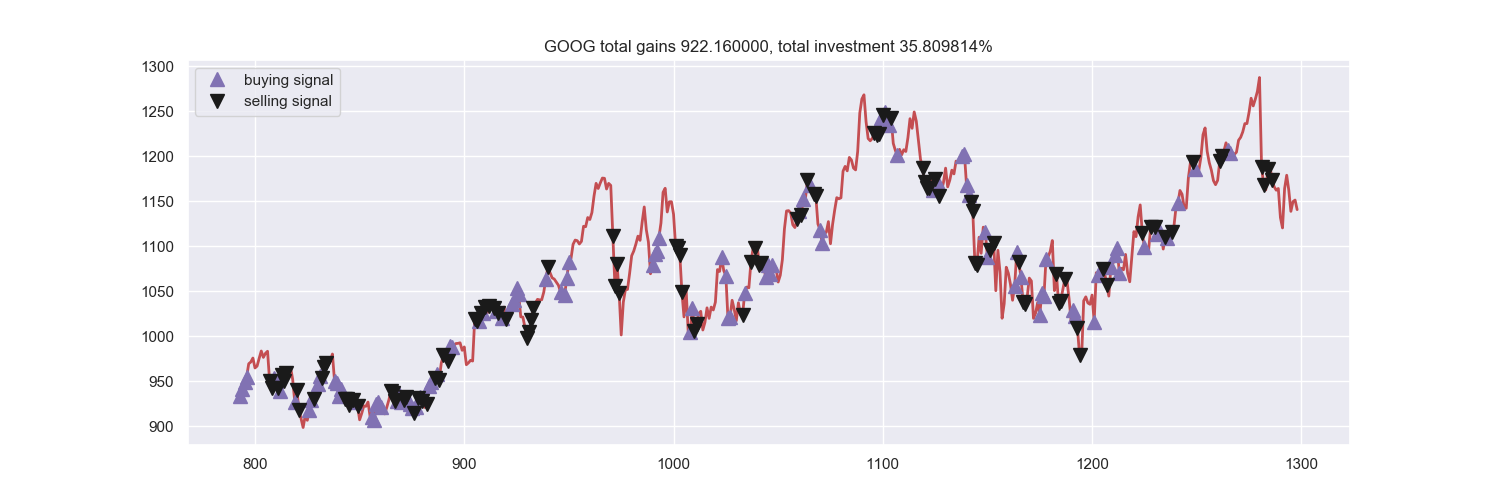

In [15]:
fig = plt.figure(figsize = (15, 5))
plt.plot(df['Close'], color='r', lw=2.)
plt.plot(df['Close'], '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(df['Close'], 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('GOOG total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

In [16]:
# df = pd.read_csv('TWTR.csv')
df = EquityToLegacyDataConversionService.get_symbol("TWTR", num_records=days_desired, latest_date=latest_date)
real_trend = df['Close'].tolist()
parameters = [df['Close'].tolist(), df['Volume'].tolist()]
minmax = MinMaxScaler(feature_range = (100, 200)).fit(np.array(parameters).T)
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
initial_money = np.max(parameters[0]) * 2

agent.change_data(timeseries = scaled_parameters,
                  skip = skip,
                  initial_money = initial_money,
                  real_trend = real_trend,
                  minmax = minmax)

states_buy, states_sell, total_gains, invest = agent.buy()

C:\Users\Chris\workspaces\stock-predictor\services\EquityToLegacyDataConversionService.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df.sort_values(by='date', inplace=True)


0 [0. 1. 0.]
day 0: buy 1 unit at price 18.350000, total balance 75.170000
1 [0. 1. 0.]
day 1: buy 1 unit at price 18.430000, total balance 56.740000
2 [0. 1. 0.]
day 2: buy 1 unit at price 18.150000, total balance 38.590000
3 [1. 0. 0.]
4 [0. 1. 0.]
5 [1. 0. 0.]
6 [1. 0. 0.]
7 [0. 1. 0.]
8 [0. 1. 0.]
9 [1. 0. 0.]
10 [0. 1. 0.]
11 [0. 1. 0.]
12 [1. 0. 0.]
13 [0. 0. 1.]
day 13, sell 1 unit at price 17.590000, investment -4.141689 %, total balance 56.180000,
14 [1. 0. 0.]
15 [0. 1. 0.]
day 15: buy 1 unit at price 17.040000, total balance 39.140000
16 [0. 1. 0.]
17 [1. 0. 0.]
18 [0. 0. 1.]
day 18, sell 1 unit at price 16.830000, investment -8.681498 %, total balance 55.970000,
19 [1. 0. 0.]
20 [1. 0. 0.]
21 [1. 0. 0.]
22 [0. 0. 1.]
day 22, sell 1 unit at price 17.780000, investment -2.038567 %, total balance 73.750000,
23 [1. 0. 0.]
24 [0. 1. 0.]
day 24: buy 1 unit at price 18.500000, total balance 55.250000
25 [0. 1. 0.]
day 25: buy 1 unit at price 18.290000, total balance 36.960000
26 [

215 [0. 0. 1.]
216 [0. 0. 1.]
217 [1. 0. 0.]
218 [0. 1. 0.]
day 218: buy 1 unit at price 27.540000, total balance 55.130000
219 [1. 0. 0.]
220 [0. 0. 1.]
day 220, sell 1 unit at price 28.640000, investment 3.994190 %, total balance 83.770000,
221 [0. 0. 1.]
222 [1. 0. 0.]
223 [1. 0. 0.]
224 [1. 0. 0.]
225 [0. 0. 1.]
226 [1. 0. 0.]
227 [1. 0. 0.]
228 [0. 1. 0.]
day 228: buy 1 unit at price 31.840000, total balance 51.930000
229 [1. 0. 0.]
230 [0. 0. 1.]
day 230, sell 1 unit at price 31.540000, investment -0.942211 %, total balance 83.470000,
231 [1. 0. 0.]
232 [1. 0. 0.]
233 [0. 1. 0.]
day 233: buy 1 unit at price 30.470000, total balance 53.000000
234 [0. 1. 0.]
day 234: buy 1 unit at price 29.750000, total balance 23.250000
235 [0. 1. 0.]
236 [0. 1. 0.]
237 [0. 0. 1.]
day 237, sell 1 unit at price 30.310000, investment -0.525107 %, total balance 53.560000,
238 [0. 1. 0.]
day 238: buy 1 unit at price 30.300000, total balance 23.260000
239 [0. 0. 1.]
day 239, sell 1 unit at price 30.550

434 [0. 0. 1.]
day 434, sell 1 unit at price 30.230000, investment -2.389409 %, total balance 75.560000,
435 [0. 0. 1.]
436 [0. 0. 1.]
437 [0. 0. 1.]
438 [0. 0. 1.]
439 [0. 0. 1.]
440 [1. 0. 0.]
441 [0. 0. 1.]
442 [1. 0. 0.]
443 [0. 0. 1.]
444 [1. 0. 0.]
445 [0. 0. 1.]
446 [1. 0. 0.]
447 [0. 0. 1.]
448 [1. 0. 0.]
449 [1. 0. 0.]
450 [1. 0. 0.]
451 [0. 1. 0.]
day 451: buy 1 unit at price 30.120000, total balance 45.440000
452 [0. 1. 0.]
day 452: buy 1 unit at price 30.040000, total balance 15.400000
453 [0. 1. 0.]
454 [0. 1. 0.]
455 [0. 1. 0.]
456 [0. 1. 0.]
457 [1. 0. 0.]
458 [1. 0. 0.]
459 [1. 0. 0.]
460 [1. 0. 0.]
461 [1. 0. 0.]
462 [0. 0. 1.]
day 462, sell 1 unit at price 33.020000, investment 9.628154 %, total balance 48.420000,
463 [0. 1. 0.]
day 463: buy 1 unit at price 32.590000, total balance 15.830000
464 [0. 1. 0.]
465 [1. 0. 0.]
466 [0. 1. 0.]
467 [0. 1. 0.]
468 [0. 0. 1.]
day 468, sell 1 unit at price 33.440000, investment 11.318242 %, total balance 49.270000,
469 [0. 0. 1.]

<IPython.core.display.Javascript object>


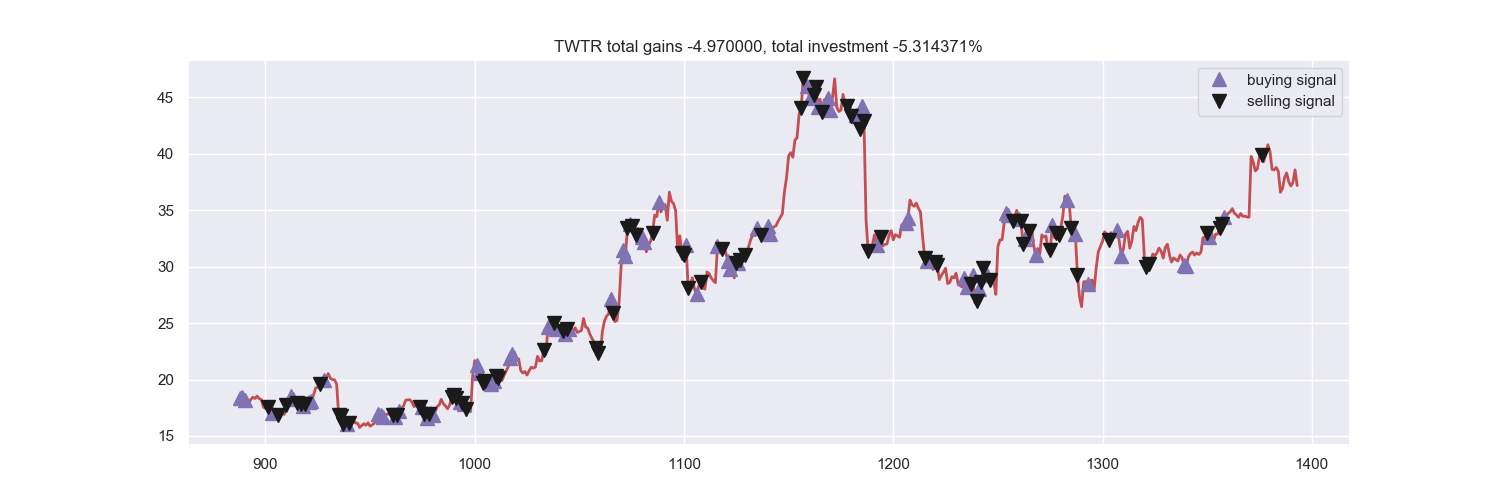

In [17]:
fig = plt.figure(figsize = (15, 5))
plt.plot(df['Close'], color='r', lw=2.)
plt.plot(df['Close'], '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(df['Close'], 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('TWTR total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

In [18]:
from datetime import datetime

volume = df['Volume'].tolist()

for i in range(100):
    print(agent.trade([real_trend[i], volume[i]]))

{'status': 'data not enough to trade', 'action': 'fail', 'balance': 93.52, 'timestamp': '2019-08-18 05:08:30.366336'}
{'status': 'data not enough to trade', 'action': 'fail', 'balance': 93.52, 'timestamp': '2019-08-18 05:08:30.366336'}
{'status': 'data not enough to trade', 'action': 'fail', 'balance': 93.52, 'timestamp': '2019-08-18 05:08:30.366336'}
{'status': 'data not enough to trade', 'action': 'fail', 'balance': 93.52, 'timestamp': '2019-08-18 05:08:30.366336'}
{'status': 'data not enough to trade', 'action': 'fail', 'balance': 93.52, 'timestamp': '2019-08-18 05:08:30.366336'}
{'status': 'data not enough to trade', 'action': 'fail', 'balance': 93.52, 'timestamp': '2019-08-18 05:08:30.366336'}
{'status': 'data not enough to trade', 'action': 'fail', 'balance': 93.52, 'timestamp': '2019-08-18 05:08:30.366336'}
{'status': 'data not enough to trade', 'action': 'fail', 'balance': 93.52, 'timestamp': '2019-08-18 05:08:30.366336'}
{'status': 'data not enough to trade', 'action': 'fail',

[0. 1. 0.]
{'status': 'do nothing', 'action': 'nothing', 'balance': 37.27000000000001, 'timestamp': '2019-08-18 05:08:30.555477'}
[0. 1. 0.]
{'status': 'do nothing', 'action': 'nothing', 'balance': 37.27000000000001, 'timestamp': '2019-08-18 05:08:30.558484'}
[0. 1. 0.]
{'status': 'do nothing', 'action': 'nothing', 'balance': 37.27000000000001, 'timestamp': '2019-08-18 05:08:30.562478'}
[0. 1. 0.]
{'status': 'do nothing', 'action': 'nothing', 'balance': 37.27000000000001, 'timestamp': '2019-08-18 05:08:30.565539'}
[0. 1. 0.]
{'status': 'do nothing', 'action': 'nothing', 'balance': 37.27000000000001, 'timestamp': '2019-08-18 05:08:30.569483'}
[1. 0. 0.]
{'status': 'do nothing', 'action': 'nothing', 'balance': 37.27000000000001, 'timestamp': '2019-08-18 05:08:30.572481'}
[0. 1. 0.]
{'status': 'do nothing', 'action': 'nothing', 'balance': 37.27000000000001, 'timestamp': '2019-08-18 05:08:30.576484'}
[0. 1. 0.]
{'status': 'do nothing', 'action': 'nothing', 'balance': 37.27000000000001, 'ti

In [19]:
import copy
import pickle

copy_model = copy.deepcopy(agent.model)

with open('model.pkl', 'wb') as fopen:
    pickle.dump(copy_model, fopen)